In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.   **Import anything**


*   **아래의 경로들은 데이터셋을 불러오는 경로입니다.**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
from time import time
warnings.filterwarnings(action='ignore')
import tensorflow as tf

In [3]:
calltaxidata = '/content/drive/MyDrive/TEAM_ML/ML/DataSet/calltaxi.csv'
stationdata='/content/drive/MyDrive/TEAM_ML/ML/DataSet/chargestation.csv'
liveindata = '/content/drive/MyDrive/TEAM_ML/ML/DataSet/livein.csv'
schooldata = '/content/drive/MyDrive/TEAM_ML/ML/DataSet/school.csv'
csv1='/content/drive/MyDrive/TEAM_ML/ML/DataSet/data_file_csv.csv'
csv_final='/content/drive/MyDrive/TEAM_ML/ML/DataSet/data_file_csv_final.csv'

In [4]:
orig_data = pd.read_csv(csv1, encoding='cp949')
orig_data.head()

,Unnamed: 0,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,ride,receipt-ride,hour,startlat,startlon,endlat,endlon
0,1,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,영등포구,당산제2동,동작구,신대방제1동,2022/05/07 0:08,2022/05/07 0:30,22,0,37.53,126.90,37.49,126.90
1,2,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,구로구,신도림동,관악구,남현동,2022/05/07 0:08,2022/05/07 0:46,38,0,37.50,126.88,37.47,126.97
2,3,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,노원구,상계3.4동,노원구,하계1동,2022/05/07 0:09,2022/05/07 0:54,45,0,37.67,127.08,37.64,127.07
3,4,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,중랑구,상봉제2동,강동구,천호제1동,2022/05/07 0:13,2022/05/07 0:14,1,0,37.59,127.08,37.54,127.13
4,5,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,중랑구,신내2동,동대문구,전농제3동,2022/05/07 0:18,2022/05/07 1:33,75,0,37.61,127.09,37.57,127.06


In [5]:
livein_d = pd.read_csv(liveindata, encoding = 'CP949')
school_d = pd.read_csv(schooldata, encoding = 'CP949')
station_d = pd.read_csv(stationdata, encoding = 'cp949')

2.   **Make Functions**

In [6]:
#딕셔너리에 키 값을 대입해 벨류값을 얻어오는 함수
def get_value(k,dic):
    for key, value in dic.items():
         if k == key:
            return value

#string, float등 의사결정나무에서는 사용하기 힘든 변수를 사용할 수 있게끔 만들어주는 함수
def get_index(name):
    temp_list = orig_data[name].tolist()
    temp_set = set(temp_list)
    temp_list2 = list(temp_set)
    dic= {string:i for i,string in enumerate(temp_list2)}

    for i in range(len(temp_list)):
        temp = orig_data.loc[i,name]
        temp_value = get_value(temp,dic)
        orig_data.loc[i,name] = temp_value

3.   **Show EDA**

In [7]:
#전처리과정
#1. 구가 서울시에 포함된 경우만 데이터에 남김
gu_list = ['강서구', '양천구', '구로구', '영등포구',
              '동작구', '금천구', '관악구', '서초구',
              '강남구', '송파구', '강동구', '마포구',
              '용산구', '성동구', '광진구', '서대문구',
              '중구', '동대문구', '중랑구', '은평구',
              '종로구', '성북구', '강북구', '도봉구', '노원구']
for i in range(len(orig_data)) :
    if orig_data.iloc[:, 8][i] not in gu_list :
        orig_data.drop(index = i, axis = 0, inplace = True)
    elif orig_data.iloc[:, 6][i] not in gu_list :
        orig_data.drop(index = i, axis = 0, inplace = True)
#2. 변수 startlat과 startlon, 변수 endlat과 endlon을 합치는 작업
for i in range (len(orig_data)):
    orig_data.loc[i,'startplus'] = ['1']
    orig_data.loc[i,'endplus'] = ['1']
    a1 = orig_data.loc[i,'startlat']
    b1 = orig_data.loc[i,'startlon']
    a1 = a1 * 10
    b1 = b1 * 10
    a1 = a1 % 100
    b1 = b1 % 100
    a1 = int(a1)
    b1 = int(b1)
    new1 = a1*100 + b1
    orig_data.loc[i,'startplus'] = [new1]
    a2 = orig_data.loc[i,'endlat']
    b2 = orig_data.loc[i,'endlon']
    a2 = a2 * 10
    b2 = b2 * 10
    a2 = a2 % 100
    b2 = b2 % 100
    a2 = int(a2)
    b2 = int(b2)
    new2 = a2*100 + b2
    new2 =  str(new2)
    orig_data.loc[i,'endplus'] = [new2]
#4. 장애인분들의 이동목적에 따라 인코딩
#일터로의 이동열을 임의로 추가하기
orig_data['gotowork'] = 0
orig_data['gotoschool'] = 0
orig_data['gotocharge'] = 0
#장애인직업재활시설 데이터에서 위도 경도 데이터와
#본데이터 위도경도 데이터 비교
for i in range(len(orig_data)) :
    for j in range(len(livein_d)) :
        if orig_data.iloc[i, 16] >= (livein_d.iloc[j, 3] - 0.01) and orig_data.iloc[i, 16] <= (livein_d.iloc[j, 3] + 0.01) :
            if orig_data.iloc[i, 17] >= (livein_d.iloc[j, 4] - 0.01) and orig_data.iloc[i, 17] <= (livein_d.iloc[j, 4] + 0.01):
                orig_data.iloc[i, 20] = 1
            else :
                orig_data.iloc[i, 20] = 0
        else :
            orig_data.iloc[i, 20] = 0
    for j in range(len(school_d)) :
        if orig_data.iloc[i, 16] >= (school_d.iloc[j, 1] - 0.01) and orig_data.iloc[i, 16] <= (school_d.iloc[j, 1] + 0.01) :
            if orig_data.iloc[i, 17] >= (school_d.iloc[j, 2] - 0.01) and orig_data.iloc[i, 17] <= (school_d.iloc[j, 2] + 0.01):
                orig_data.iloc[i, 21] = 1
            else :
                orig_data.iloc[i, 21] = 0
        else :
            orig_data.iloc[i, 21] = 0
    for j in range(len(station_d)) :
        if orig_data.iloc[i, 16] >= (station_d.iloc[j, 4] - 0.01) and orig_data.iloc[i, 16] <= (station_d.iloc[j, 4] + 0.01) :
            if orig_data.iloc[i, 17] >= (station_d.iloc[j, 5] - 0.01) and orig_data.iloc[i, 17] <= (station_d.iloc[j, 5] + 0.01):
                orig_data.iloc[i, 22] = 1
            else :
                orig_data.iloc[i, 22] = 0
        else :
            orig_data.iloc[i, 22] = 0
#5. startpos1, startpos2, endpos1, endpos2를 숫자로 바꾸어주는 작업
get_index('startpos1')
get_index('startpos2')
get_index('endpos1')
get_index('endpos2')
orig_data['startpos1'] = pd.to_numeric(orig_data['startpos1'])
orig_data['startpos2'] = pd.to_numeric(orig_data['startpos2'])
#6. 이동목적 변수를 3가지 범주로 다시 변환
# list로 만들기
list_gotowork=orig_data['gotowork'].to_list()
list_gotoschool=orig_data['gotoschool'].to_list()
list_gotocharge=orig_data['gotocharge'].to_list()
# end_destination에 연산결과 추가하기
for i in range(len(orig_data)):
    if (list_gotowork[i] *100+
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 100) :
        orig_data.loc[i, 'end_destination'] = int(3)
    elif (list_gotowork[i] *100+
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        orig_data.loc[i, 'end_destination'] = int(2)
    elif (list_gotowork[i] *100+
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 1) :
        orig_data.loc[i, 'end_destination'] = int(1)
    else :
        orig_data.loc[i, 'end_destination'] = int(0)
orig_data.drop(columns=["Unnamed: 0"],inplace=True)
orig_data.head()

,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,...,startlat,startlon,endlat,endlon,startplus,endplus,gotowork,gotoschool,gotocharge,end_destination
0,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,18,59,6,320,2022/05/07 0:08,...,37.53,126.90,37.49,126.90,[7569],[7469],0,0,0,0.0
1,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,4,232,0,175,2022/05/07 0:08,...,37.50,126.88,37.47,126.97,[7568],[7469],0,0,0,0.0
2,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,8,265,8,10,2022/05/07 0:09,...,37.67,127.08,37.64,127.07,[7670],[7670],0,0,0,0.0
3,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,17,128,19,63,2022/05/07 0:13,...,37.59,127.08,37.54,127.13,[7570],[7571],0,0,0,0.0
4,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,17,235,20,247,2022/05/07 0:18,...,37.61,127.09,37.57,127.06,[7670],[7570],0,0,0,0.0


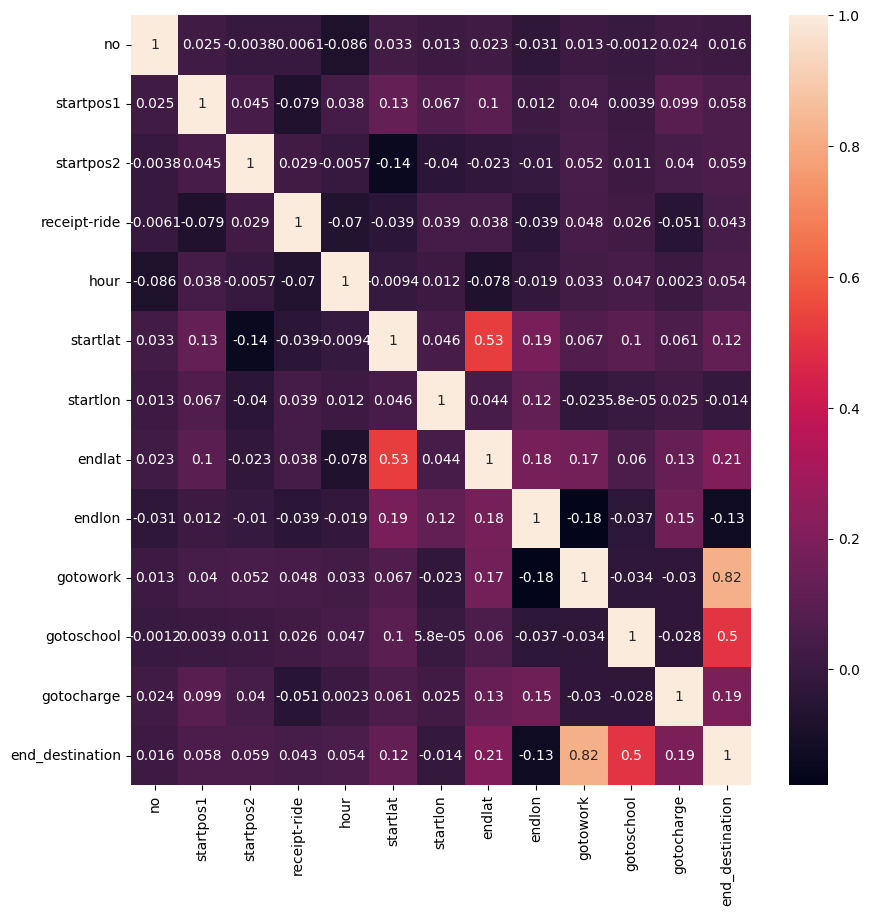

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(orig_data.corr(), annot=True)
plt.show()

4.   **Save to CSV**

In [9]:
#csv파일 따로 저장
orig_data.to_csv(csv_final)